In [2]:
#importing required libraries.
import cv2
import numpy as np
import matplotlib.pyplot as plt 

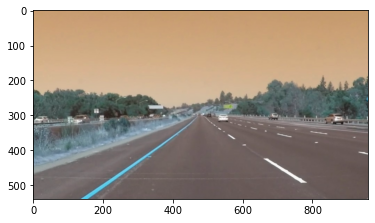

In [3]:
image = cv2.imread('solidYellowLeft.jpg')
plt.imshow(image)
plt.show()

In [4]:
#step1:function for canny edge detection
def canny(image):
    #converting image from RGB to grayscale.
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    #applying gaussianblur on the input.
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    #applying canny edge detection on the input. 
    canny = cv2.Canny(blur, 50, 150)
    return canny

In [5]:
#step2:getting the region of interest from the input.
def roi(image):
    height = image.shape[0]
    polygons = np.array([[(0, height), (490, 310), (890, height)]], np.int32)
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [6]:
#step3:getting straight lines
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None: 
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (0,0,255), 3)
    return line_image

In [7]:
#step4:a fuction that returns all the coordinates
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3.5/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1, y1, x2, y2])
    

In [8]:
#step5:function for getting smooth lines in the output.
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    
    
    # Ensure that list are not empty
    if len(right_fit) == len(left_fit) == 0:
        return np.array([])
    if len(left_fit) == 0:
        right_fit_avg = np.average(right_fit, axis=0)
        right_line = make_coordinates(image, right_fit_avg)
        return np.array([right_line])
    elif len(right_fit) == 0:
        left_fit_avg = np.average(left_fit, axis=0)
        left_line = make_coordinates(image, left_fit_avg)
        return np.array([left_line])

    left_fit_avg = np.average(left_fit, axis=0)
    right_fit_avg = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_avg)
    right_line = make_coordinates(image, right_fit_avg)
    return np.array([left_line, right_line])
  

In [ ]:
#script for applying lane detection on videos. 

#Video = cv2.VideoCapture("solidYellowLeft.mp4")
Video = cv2.VideoCapture("solidWhiteRight.mp4")
while(Video.isOpened()):
    _, frame = Video.read()
    canny_image = canny(frame)
    cropped_image = roi(canny_image)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(frame, lines)
    line_image = display_lines(frame, averaged_lines)
    combine_image = cv2.addWeighted(frame, 0.8, line_image, 1, 1)
    cv2.imshow("Lane Detection", combine_image)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    else:
        continue
Video.release()
cv2.destroyAllWindows()
    